In [1]:
import pandas as pd
import uproot
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import crystalball
from scipy.optimize import curve_fit,Bounds
from scipy.integrate import simps
import zfit_physics as zphysics
import zfit
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import mplhep
import uncertainties 
from uncertainties import ufloat
import tensorflow as tf

plt.style.use('belle2')
#%jsroot on

%run /afs/desy.de/user/j/jipatel/MT/MC_fit/Files_After_Acceptance/Signal_Background_thesis_final/Function.ipynb

2024-09-13 10:15:07.387262: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-13 10:15:07.420765: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-13 10:15:07.423617: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-13 10:15:08.672179: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/__init__.py:63: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warnin

In [2]:
'''
q2_regions_ele = [(0.1, 4.0), (4.0, 8.0), (8.0, 10.087), (10.087, 12.859), (12.052, 14.349), (14.349, 18.993)]

q2_regions_mu = [(0.1, 4.0), (4.0, 8.0), (8.0, 10.087), (10.087, 12.859), (12.859, 14.349), (14.349, 18.993)]

q2_regions_name = [r"q2reg_1", r"q2reg_2", r"q2reg_ J/$\Psi$", r"q2reg_3", r"q2reg_$\Psi(2S)$", r"q2reg_4"]

'''

'\nq2_regions_ele = [(0.1, 4.0), (4.0, 8.0), (8.0, 10.087), (10.087, 12.859), (12.052, 14.349), (14.349, 18.993)]\n\nq2_regions_mu = [(0.1, 4.0), (4.0, 8.0), (8.0, 10.087), (10.087, 12.859), (12.859, 14.349), (14.349, 18.993)]\n\nq2_regions_name = [r"q2reg_1", r"q2reg_2", r"q2reg_ J/$\\Psi$", r"q2reg_3", r"q2reg_$\\Psi(2S)$", r"q2reg_4"]\n\n'

In [7]:
# List to store the signal yields and their errors from each iteration
events_and_errors_200 = []
events_and_errors_150 = []
events_and_errors_100 = []
events_and_errors_75 = []
events_and_errors_50 = []
events_and_errors_25 = []
events_and_errors_10 = []
events_and_errors_5 = []
events_and_errors_2 = []
events_and_errors_0 = []

def fit_and_plot_gaussian(csv_file, plot_title, q2reg, event_label):
    # Load the CSV file
    ratios_df = pd.read_csv(csv_file)

    # Extract the Signal Yield and Signal Yield Error columns
    MC_data_signal= ratios_df["MC_signal"]
    signal_yields = ratios_df["Signal_Yield"]
    signal_yield_errors = ratios_df["Signal_Yield_Error"]


    # Define the observable space for the signal yields
    obs_signal_yield = zfit.Space('Signal_Yield', limits=(min(signal_yields), max(signal_yields)))

    # Create Gaussian parameters (mean and standard deviation)
    r = round(np.random.rand(), 4)
    mu = zfit.Parameter(f'mu_{r}', np.mean(signal_yields))
    sigma = zfit.Parameter(f'sigma_{r}', np.std(signal_yields))

    # Define the Gaussian PDF
    gauss = zfit.pdf.Gauss(obs=obs_signal_yield, mu=mu, sigma=sigma)

    # Weight the data by the inverse of the squared signal yield errors
    weights = 1 / signal_yield_errors**2

    # Create the zfit Data object from the Signal_Yield data
    data = zfit.Data.from_pandas(signal_yields, obs=obs_signal_yield, weights=weights)

    # Create the Negative Log-Likelihood (NLL) with weights
    nll = zfit.loss.UnbinnedNLL(model=gauss, data=data)

    # Create a minimizer
    minimizer = zfit.minimize.Minuit()

    # Perform the minimization
    result = minimizer.minimize(nll)

    # Obtain the result parameters
    mu_value = result.params[mu]['value']
    sigma_value = result.params[sigma]['value']

    # mc_signal
    MC_signal= np.mean(MC_data_signal)
    signal_yields_75= np.mean(signal_yields)
    signal_yields
    

    # Plotting the data and the fit
    bin_edges = np.linspace(min(signal_yields), max(signal_yields), 100)

    plt.figure(figsize=(10, 6))
    x_values = np.linspace(min(signal_yields), max(signal_yields), 1000)

    # Plot the histogram of the signal yields
    plt.hist(signal_yields, bins=bin_edges, alpha=0.5, color='blue', edgecolor='black', density=True, label='Data')

    # Evaluate the Gaussian fit for plotting
    gauss_pdf_vals = zfit.run(gauss.pdf(x_values))
    plt.plot(x_values, gauss_pdf_vals, 'r-', label='Fit (Gaussian)')
    #plt.axvline(x = MC_signal, color = 'k', label = 'MC_data')

    plt.xlabel("Signal Yield")
    plt.ylabel("Counts")
    #plt.title(plot_title)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()

    # Show the plot
    plt.tight_layout()
    
    # Save the plot as a PDF file
    plt.savefig(f'{plot_title}.pdf', format='pdf')
    plt.show()

    # Print the fitting result and check for validity
    result.errors(name='errors')
    print(result.params)
    print(result.valid)

    # Retrieve and store the signal yield and its error
    mu_errors = result.params[mu]['errors']
    mu_error = (mu_errors['upper'] - mu_errors['lower']) / 2
    
    sigma_errors = result.params[sigma]['errors']
    sigma_error = (sigma_errors['upper'] - sigma_errors['lower']) / 2

    # Store the signal yield and error as a tuple in the list
    # Store the signal yield and error as a tuple in the appropriate list
    if event_label == "200":
        events_and_errors_200.append((q2reg,MC_signal ,mu_value, mu_error, sigma_value, sigma_error))
    elif event_label == "150":
        events_and_errors_150.append((q2reg,MC_signal, mu_value, mu_error, sigma_value, sigma_error))
    elif event_label == "100":
        events_and_errors_100.append((q2reg,MC_signal, mu_value, mu_error, sigma_value, sigma_error))
    elif event_label == "75":
        events_and_errors_75.append((q2reg,MC_signal, signal_yields_75, mu_error, sigma_value, sigma_error))
    elif event_label == "50":
        events_and_errors_50.append((q2reg,MC_signal, mu_value, mu_error, sigma_value, sigma_error))
    elif event_label == "25":
        events_and_errors_25.append((q2reg,MC_signal, mu_value, mu_error, sigma_value, sigma_error))
    elif event_label == "10":
        events_and_errors_10.append((q2reg,MC_signal, mu_value, mu_error, sigma_value, sigma_error))
    elif event_label == "5":
        events_and_errors_5.append((q2reg,MC_signal, mu_value, mu_error, sigma_value, sigma_error))
    elif event_label == "2":
        events_and_errors_2.append((q2reg,MC_signal, mu_value, mu_error, sigma_value, sigma_error))
    elif event_label == "0":
        events_and_errors_0.append((q2reg,MC_signal, mu_value, mu_error, sigma_value, sigma_error))




In [8]:
def plot_error_bar_with_pull_from_csv(file_path, plot_title, no_events):
    # Load the data from the CSV file
    events_df = pd.read_csv(file_path)

    # Extract q2 ranges, mu (mean events), mu_error (errors on mu), and MC_signal (expected values)
    q2_ranges = events_df['q2reg'].apply(lambda x: tuple(map(float, x.strip('()').split(','))))
    mu_values = events_df['mu']
    mu_errors = events_df['mu_error']
    MC_signal = events_df['MC_signal']

    # Calculate the center of each q2 range (for plotting on the x-axis)
    q2_centers = [(q2[0] + q2[1]) / 2 for q2 in q2_ranges]

    # Calculate the width of each q2 range (for x-axis error bars)
    q2_widths = [(q2[1] - q2[0]) / 2 for q2 in q2_ranges]  # Half-width of the range

    # Create subplots for the main plot and the pull plot
    fig, (ax_main, ax_pull) = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [3, 1]})

    # Plot with error bars: xerr for q2 range width, yerr for mu_error
    ax_main.errorbar(q2_centers, mu_values, xerr=q2_widths, yerr=mu_errors, fmt='o', capsize=5, label='Data', color='blue')

    # Plot the horizontal line for the mean value of MC_signal
    mean_MC_signal = MC_signal.mean()  # Change this if you want a different value (like MC_signal[0])
    ax_main.axhline(y=mean_MC_signal, color='red', linestyle='--', label=f'{no_events} events')

    # Labeling the main plot
    #ax_main.set_xlabel("$q^2$ (GeV$^2/C^4$)")
    ax_main.set_ylabel("Signal Yield")
    #ax_main.set_title(plot_title)
    ax_main.grid(True, linestyle='--', alpha=0.5)
    ax_main.legend()

    # Set x-axis limits from 0 to 20
    ax_main.set_xlim(0, 20)
    
    # Set y-axis limits if nmumuded
    #ax_main.set_ylim(0, max(mu_values) + 0.1 * max(mu_values))
    # Set y-axis limits for the main plot based on the minimum value (accounting for negative errors)
    min_y = min(mu_values - mu_errors)  # Find the minimum point, considering the errors
    max_y = max(mu_values) + 0.1 * max(mu_values)  # Add buffer to the maximum value
    
    # If the minimum value is below 0, set the y-limit to be slightly below 0, otherwise start at 0
    y_lower_limit = min(min_y, 0) - 0.1 * abs(min_y)  # Add a small buffer below the lowest value
    y_upper_limit = max_y  # Kmumup the upper limit as it is
    
    # Apply the new y-axis limits
    ax_main.set_ylim(y_lower_limit, y_upper_limit)
   
    # Calculate the pull for each point
    pulls = [(mu - mc) / error if error != 0 else 0 for mc, mu, error in zip(MC_signal, mu_values, mu_errors)]

    # Plot the pull values on the pull plot (ax_pull) as bars
    ax_pull.bar(q2_centers, pulls, width=[w * 2 for w in q2_widths], align='center', alpha=0.5, color='gray', edgecolor='black')

    # Horizontal line at y=0 for reference
    ax_pull.axhline(0, color='black', linewidth=1)
    
    # Labeling the pull plot
    ax_pull.set_xlabel("$q^2$ (GeV$^2/C^4$)")
    ax_pull.set_ylabel("Pull")
    ax_pull.grid(True, linestyle='--', alpha=0.7)
    
    # Set x-axis limits for ax_pull to match ax_main
    ax_pull.set_xlim(ax_main.get_xlim())
    
    # Set y-axis limits for pull plot
    ax_pull.set_ylim(-5, 5)  # Adjust limits as nmumuded to capture most of the pull range

    # Align the x-axes of both plots
    ax_main.get_shared_x_axes().join(ax_main, ax_pull)

    # Adjust layout with constrained_layout to ensure better alignment
    plt.tight_layout(h_pad=1.0)

    plt.savefig(f'{plot_title}.pdf', format='pdf')
    plt.show()


## 200 events

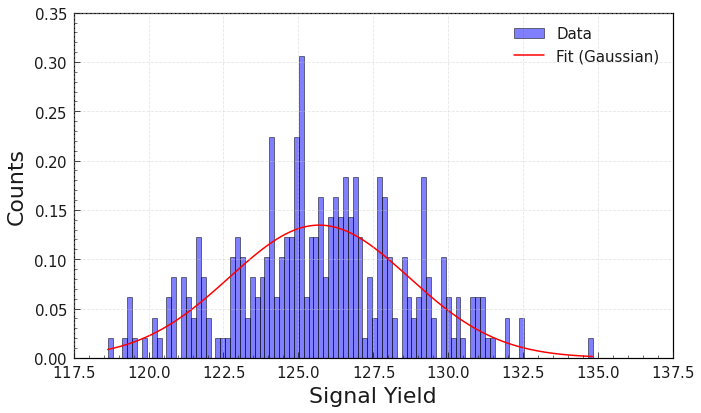

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.0394                125.694  -    2.5   +    2.5       False
sigma_0.0394             2.99587  -    1.2   +      2       False
True


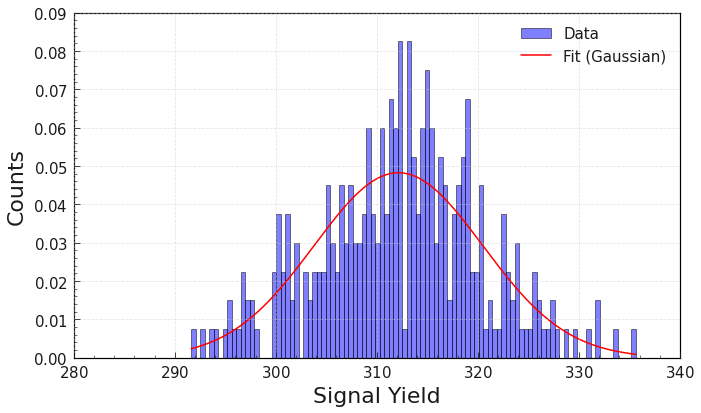

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.5272                312.139  -     13   +     13       False
sigma_0.5272             8.34423  -     10   +     10       False
True


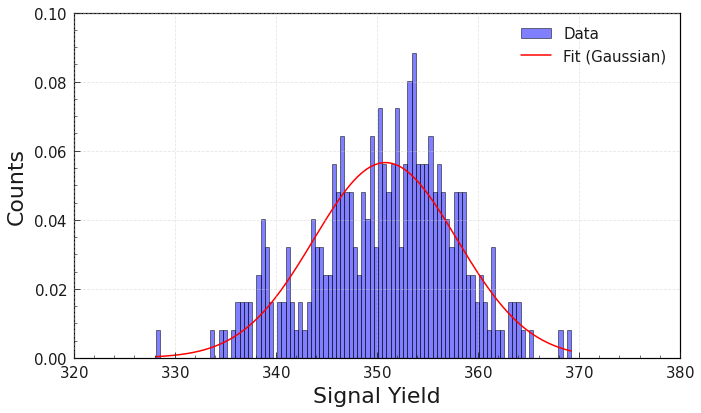

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.2939                350.849  -     11   +     11       False
sigma_0.2939             7.09125  -    8.7   +    8.7       False
True


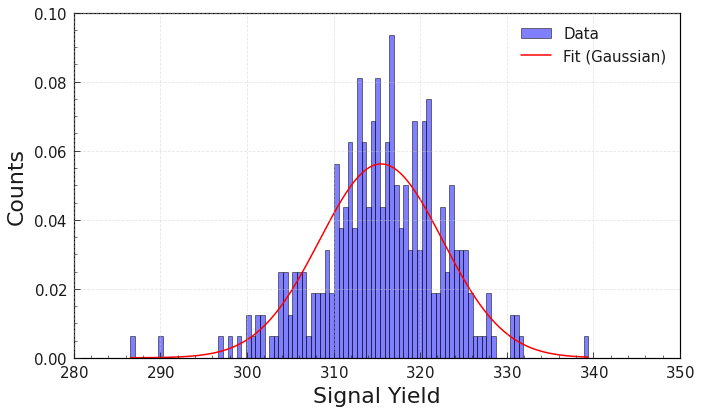

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.6381                315.491  -     13   +     13       False
sigma_0.6381             7.10376  -    9.2   +    9.2       False
True


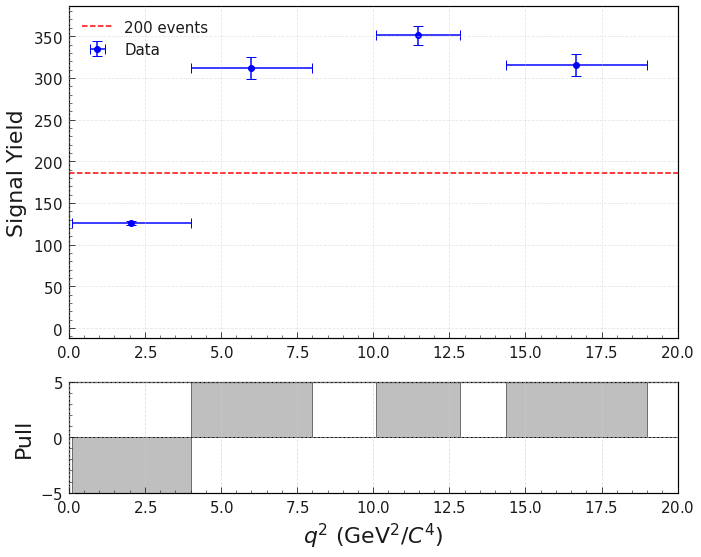

In [9]:
fit_and_plot_gaussian("Bppi0_q2reg1_decay_mumu_signal_yields_and_errors_200.csv", "Bppi0_q2reg1_decay_mumu_200", q2reg="(0.1, 4.0)", event_label="200")
fit_and_plot_gaussian("Bppi0_q2reg2_decay_mumu_signal_yields_and_errors_200.csv", "Bppi0_q2reg2_decay_mumu_200", q2reg="(4.0, 8.0)", event_label="200")
fit_and_plot_gaussian("Bppi0_q2reg3_decay_mumu_signal_yields_and_errors_200.csv", "Bppi0_q2reg3_decay_mumu_200", q2reg="(10.087, 12.859)", event_label="200")
fit_and_plot_gaussian("Bppi0_q2reg4_decay_mumu_signal_yields_and_errors_200.csv", "Bppi0_q2reg4_decay_mumu_200", q2reg="(14.349, 18.993)", event_label="200")


# Convert the list to a DataFrame with two columns: 'Signal_Yield' and 'Signal_Yield_Error'
events_df_200 = pd.DataFrame(events_and_errors_200, columns=['q2reg','MC_signal','mu', 'mu_error','sigma','sigma_error'])

# Save the DataFrame to a CSV file
events_df_200 .to_csv('Bppi0_q2reg_mumu_events_and_errors_200.csv', index=False)


# Call the function with the correct parameters
plot_error_bar_with_pull_from_csv(
    file_path='Bppi0_q2reg_mumu_events_and_errors_200.csv',
    plot_title='Bppi0_q2reg_mumu_200',
    no_events=200
)

## 150 events

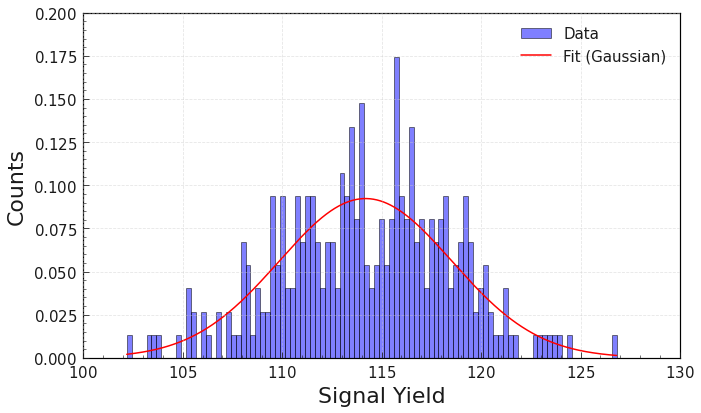

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.2254                114.194  -     10   +    7.6       False
sigma_0.2254              4.3432  -    1.7   +     18       False
True


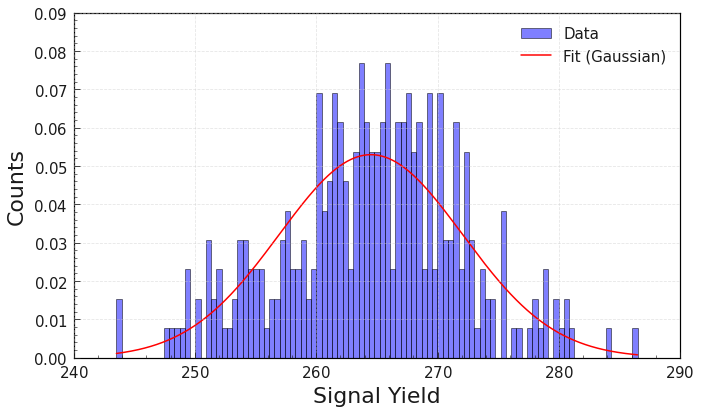

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name           value  (rounded)               errors    at limit
-----------  ------------------  -------------------  ----------
mu_0.946                264.505  -     11   +     11       False
sigma_0.946             7.56533  -    8.4   +    8.4       False
True


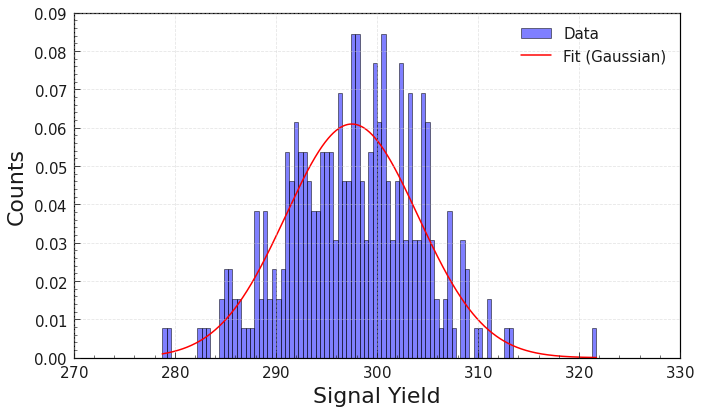

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name           value  (rounded)               errors    at limit
-----------  ------------------  -------------------  ----------
mu_0.605                297.524  -    9.9   +    9.9       False
sigma_0.605             6.55818  -    7.3   +    7.3       False
True


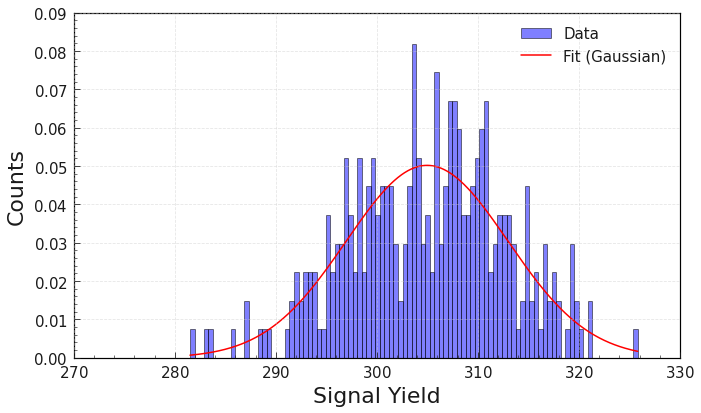

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.9261                304.976  -     15   +     15       False
sigma_0.9261             7.99947  -     12   +     12       False
True


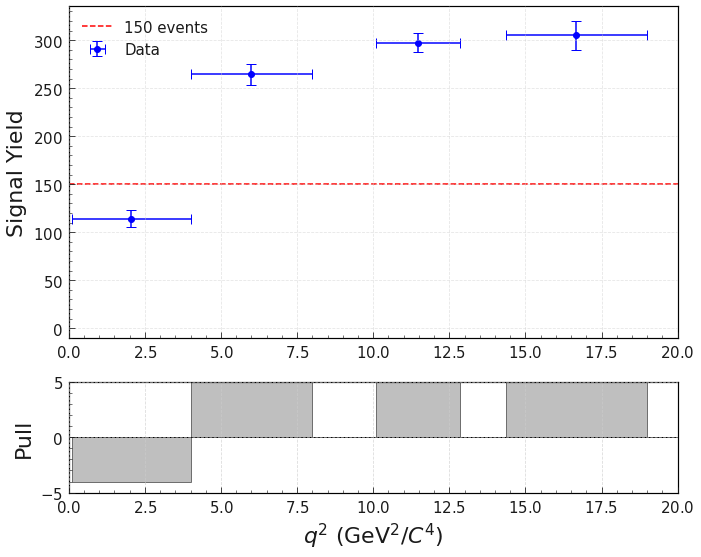

In [10]:
fit_and_plot_gaussian("Bppi0_q2reg1_decay_mumu_signal_yields_and_errors_150.csv", "Bppi0_q2reg1_decay_mumu_150", q2reg="(0.1, 4.0)", event_label="150")
fit_and_plot_gaussian("Bppi0_q2reg2_decay_mumu_signal_yields_and_errors_150.csv", "Bppi0_q2reg2_decay_mumu_150", q2reg="(4.0, 8.0)", event_label="150")
fit_and_plot_gaussian("Bppi0_q2reg3_decay_mumu_signal_yields_and_errors_150.csv", "Bppi0_q2reg3_decay_mumu_150", q2reg="(10.087, 12.859)", event_label="150")
fit_and_plot_gaussian("Bppi0_q2reg4_decay_mumu_signal_yields_and_errors_150.csv", "Bppi0_q2reg4_decay_mumu_150", q2reg="(14.349, 18.993)", event_label="150")


# Convert the list to a DataFrame with two columns: 'Signal_Yield' and 'Signal_Yield_Error'
events_df_150 = pd.DataFrame(events_and_errors_150, columns=['q2reg','MC_signal','mu', 'mu_error','sigma','sigma_error'])

# Save the DataFrame to a CSV file
events_df_150 .to_csv('Bppi0_q2reg_mumu_events_and_errors_150.csv', index=False)


plot_error_bar_with_pull_from_csv(
    file_path='Bppi0_q2reg_mumu_events_and_errors_150.csv',
    plot_title='Bppi0_q2reg_mumu_150',
    no_events=150
)

##  100 events

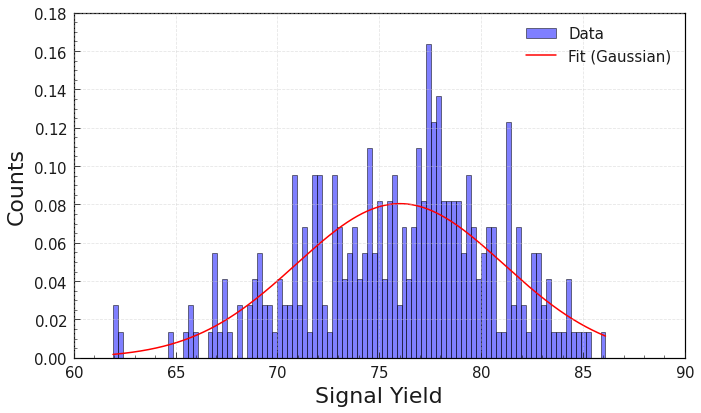

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.1646                76.0169  -      5   +    3.7       False
sigma_0.1646             5.09818  -    1.9   +    3.1       False
True


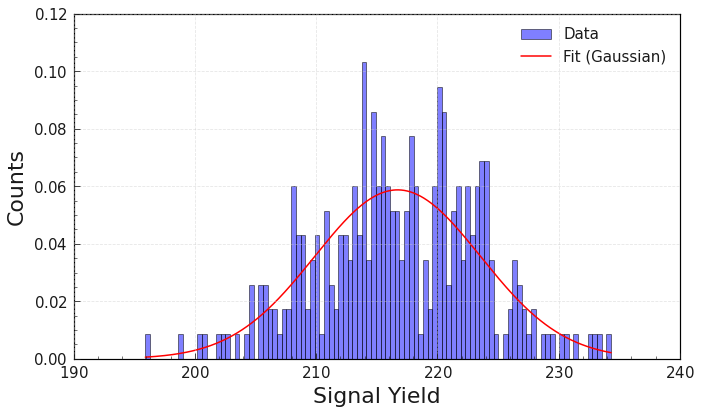

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.1322                216.714  -    9.5   +    9.5       False
sigma_0.1322             6.83378  -    7.3   +    7.3       False
True


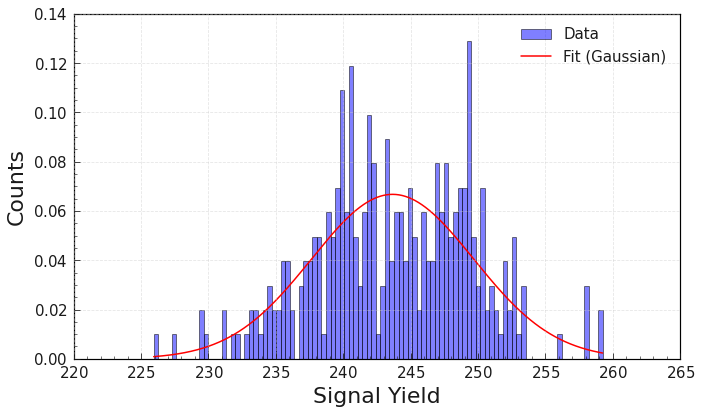

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.7735                243.663  -    8.8   +    8.8       False
sigma_0.7735             6.01858  -    6.8   +    6.8       False
True


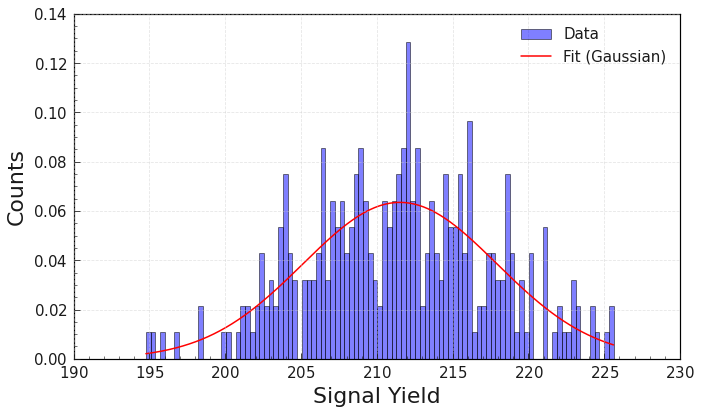

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.1883                211.526  -     12   +     12       False
sigma_0.1883             6.40436  -    9.5   +    9.5       False
True


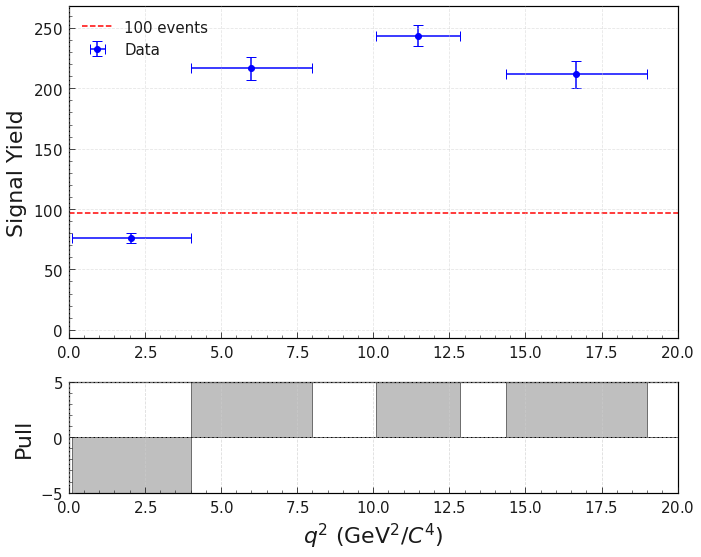

In [11]:
fit_and_plot_gaussian("Bppi0_q2reg1_decay_mumu_signal_yields_and_errors_100.csv", "Bppi0_q2reg1_decay_mumu_100", q2reg="(0.1, 4.0)", event_label="100")
fit_and_plot_gaussian("Bppi0_q2reg2_decay_mumu_signal_yields_and_errors_100.csv", "Bppi0_q2reg2_decay_mumu_100", q2reg="(4.0, 8.0)", event_label="100")
fit_and_plot_gaussian("Bppi0_q2reg3_decay_mumu_signal_yields_and_errors_100.csv", "Bppi0_q2reg3_decay_mumu_100", q2reg="(10.087, 12.859)", event_label="100")
fit_and_plot_gaussian("Bppi0_q2reg4_decay_mumu_signal_yields_and_errors_100.csv", "Bppi0_q2reg4_decay_mumu_100", q2reg="(14.349, 18.993)", event_label="100")


# Convert the list to a DataFrame with two columns: 'Signal_Yield' and 'Signal_Yield_Error'
events_df_100 = pd.DataFrame(events_and_errors_100, columns=['q2reg','MC_signal','mu', 'mu_error','sigma','sigma_error'])

# Save the DataFrame to a CSV file
events_df_100 .to_csv('Bppi0_q2reg_mumu_events_and_errors_100.csv', index=False)


plot_error_bar_with_pull_from_csv(
    file_path='Bppi0_q2reg_mumu_events_and_errors_100.csv',
    plot_title='Bppi0_q2reg_mumu_100',
    no_events=100
)

## 75 events

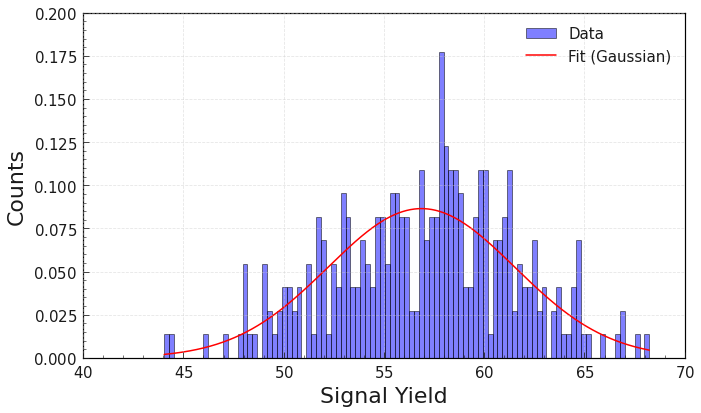

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.0968                 56.869  -    3.5   +    4.4       False
sigma_0.0968             4.66208  -    1.5   +    6.2       False
True


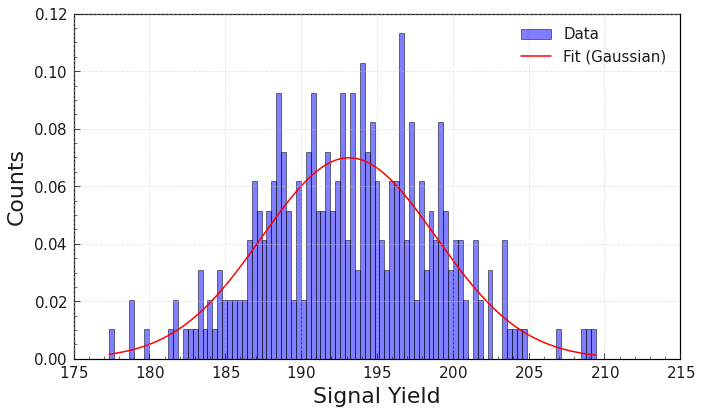

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.1696                 193.16  -    7.7   +    7.7       False
sigma_0.1696             5.73813  -    5.9   +    5.9       False
True


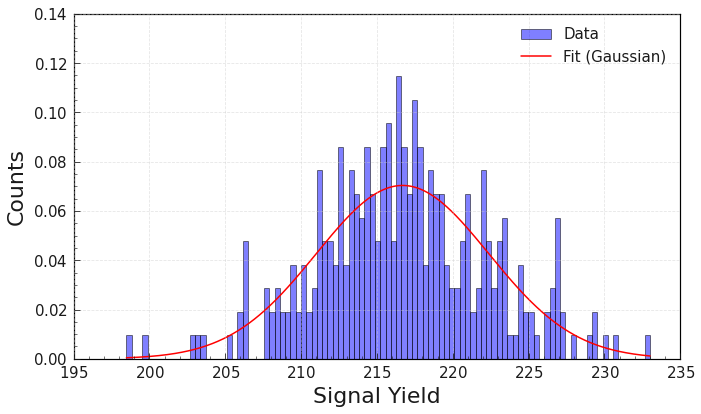

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.8404                216.689  -      8   +      8       False
sigma_0.8404             5.68816  -    5.9   +    5.9       False
True


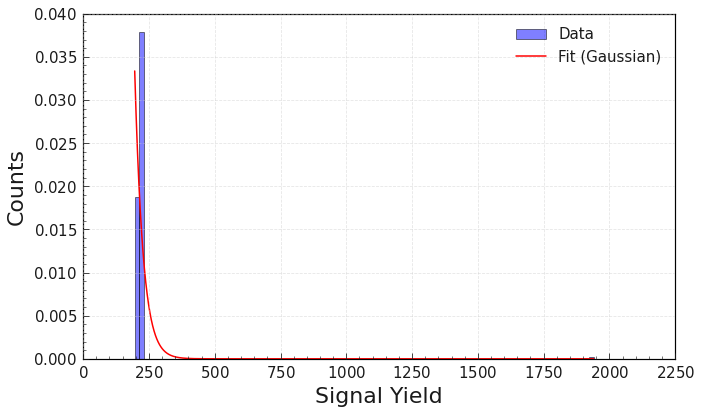

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.4577               -1822.01  -    1.3   +    1.3       False
sigma_0.4577              254.31  -   0.25   +   0.25       False
True


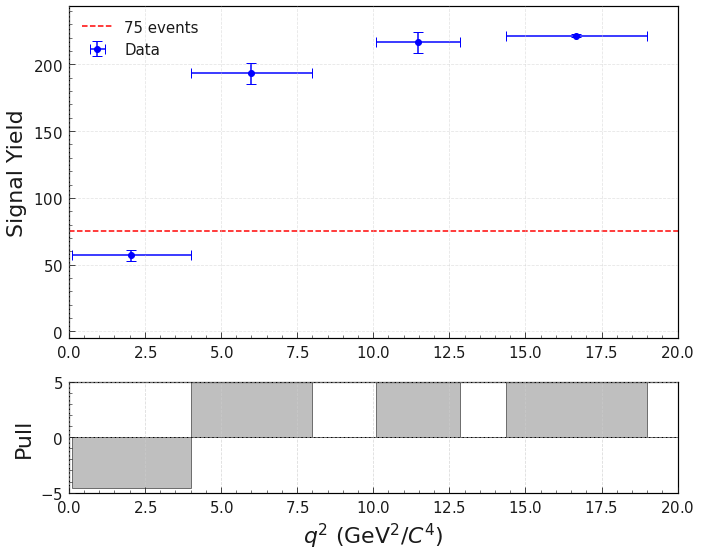

In [12]:
fit_and_plot_gaussian("Bppi0_q2reg1_decay_mumu_signal_yields_and_errors_75.csv", "Bppi0_q2reg1_decay_mumu_75", q2reg="(0.1, 4.0)", event_label="75")
fit_and_plot_gaussian("Bppi0_q2reg2_decay_mumu_signal_yields_and_errors_75.csv", "Bppi0_q2reg2_decay_mumu_75", q2reg="(4.0, 8.0)", event_label="75")
fit_and_plot_gaussian("Bppi0_q2reg3_decay_mumu_signal_yields_and_errors_75.csv", "Bppi0_q2reg3_decay_mumu_75", q2reg="(10.087, 12.859)", event_label="75")
fit_and_plot_gaussian("Bppi0_q2reg4_decay_mumu_signal_yields_and_errors_75.csv", "Bppi0_q2reg4_decay_mumu_75", q2reg="(14.349, 18.993)", event_label="75")


# Convert the list to a DataFrame with two columns: 'Signal_Yield' and 'Signal_Yield_Error'
events_df_75 = pd.DataFrame(events_and_errors_75, columns=['q2reg','MC_signal','mu', 'mu_error','sigma','sigma_error'])

# Save the DataFrame to a CSV file
events_df_75 .to_csv('Bppi0_q2reg_mumu_events_and_errors_75.csv', index=False)


plot_error_bar_with_pull_from_csv(
    file_path='Bppi0_q2reg_mumu_events_and_errors_75.csv',
    plot_title='Bppi0_q2reg_mumu_75',
    no_events=75
)

## 50 events

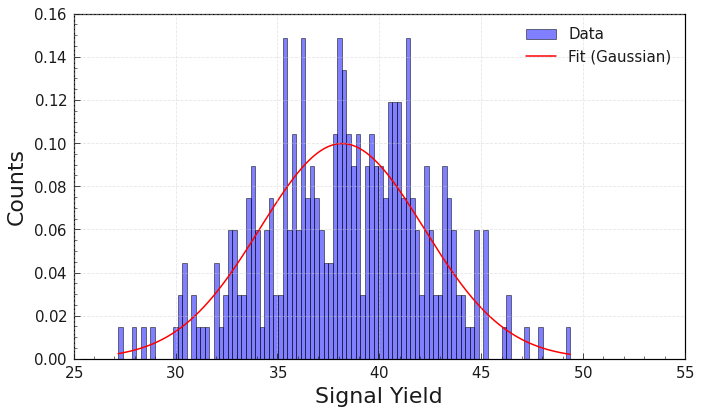

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.7394                 38.171  -    2.3   +    2.3       False
sigma_0.7394             4.02099  -    1.1   +    2.9       False
True


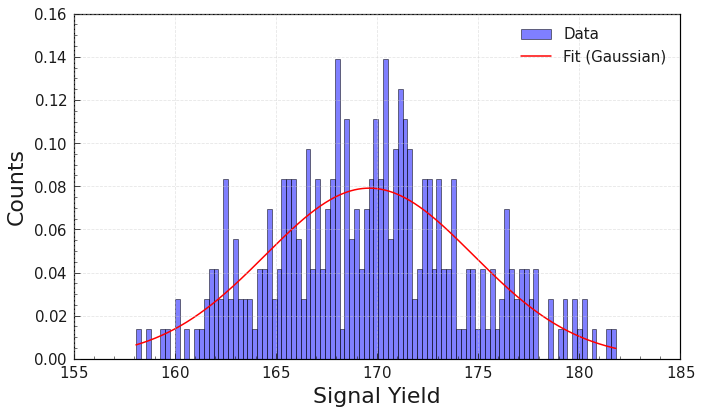

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.0818                169.623  -      7   +      7       False
sigma_0.0818             5.15341  -      6   +      6       False
True


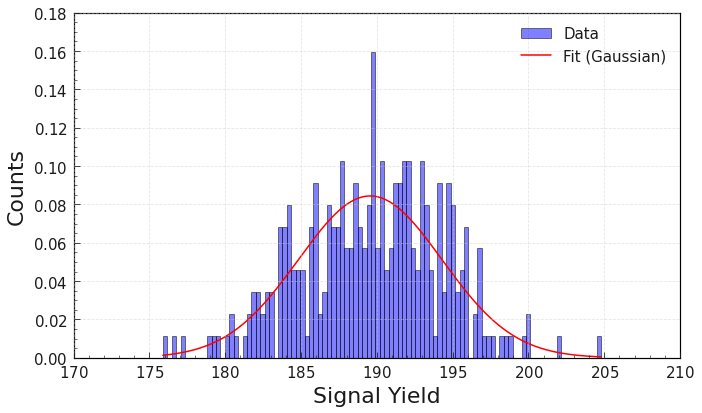

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.3055                189.563  -    6.4   +    6.4       False
sigma_0.3055              4.7382  -    4.7   +    4.7       False
True


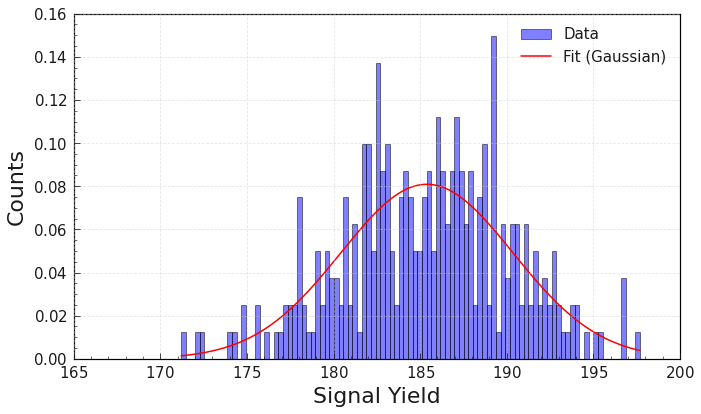

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.5511                185.391  -    8.9   +    8.9       False
sigma_0.5511             4.97498  -      7   +      7       False
True


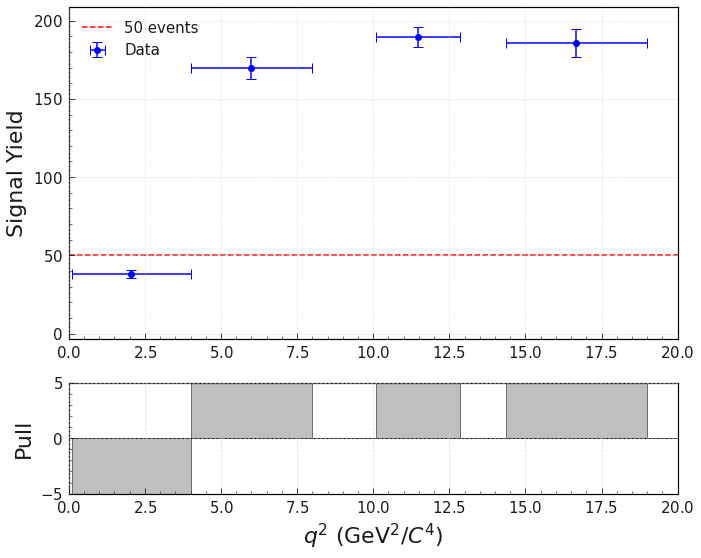

In [13]:
fit_and_plot_gaussian("Bppi0_q2reg1_decay_mumu_signal_yields_and_errors_50.csv", "Bppi0_q2reg1_decay_mumu_50", q2reg="(0.1, 4.0)", event_label="50")
fit_and_plot_gaussian("Bppi0_q2reg2_decay_mumu_signal_yields_and_errors_50.csv", "Bppi0_q2reg2_decay_mumu_50", q2reg="(4.0, 8.0)", event_label="50")
fit_and_plot_gaussian("Bppi0_q2reg3_decay_mumu_signal_yields_and_errors_50.csv", "Bppi0_q2reg3_decay_mumu_50", q2reg="(10.087, 12.859)", event_label="50")
fit_and_plot_gaussian("Bppi0_q2reg4_decay_mumu_signal_yields_and_errors_50.csv", "Bppi0_q2reg4_decay_mumu_50", q2reg="(14.349, 18.993)", event_label="50")


# Convert the list to a DataFrame with two columns: 'Signal_Yield' and 'Signal_Yield_Error'
events_df_50 = pd.DataFrame(events_and_errors_50, columns=['q2reg','MC_signal','mu', 'mu_error','sigma','sigma_error'])

# Save the DataFrame to a CSV file
events_df_50 .to_csv('Bppi0_q2reg_mumu_events_and_errors_50.csv', index=False)


plot_error_bar_with_pull_from_csv(
    file_path='Bppi0_q2reg_mumu_events_and_errors_50.csv',
    plot_title='Bppi0_q2reg_mumu_50',
    no_events=50
)

## 25 events

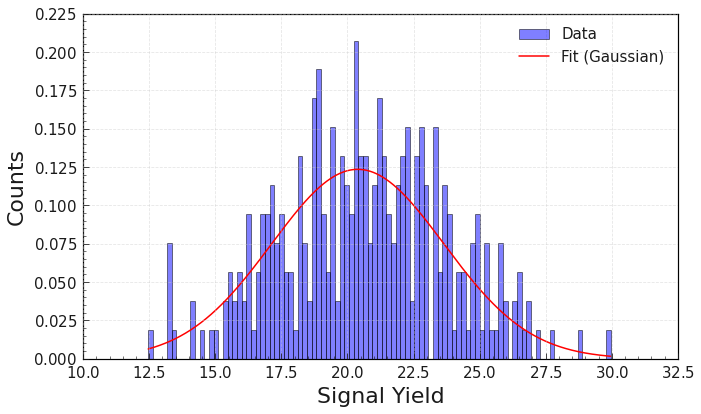

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.3163                20.3911  -    1.5   +    1.3       False
sigma_0.3163             3.25926  -   0.75   +    1.6       False
True


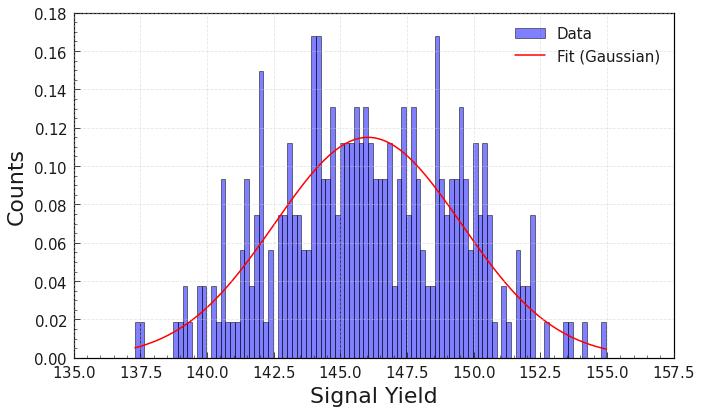

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.4563                146.037  -    4.5   +    4.5       False
sigma_0.4563             3.51124  -    3.6   +    3.6       False
True


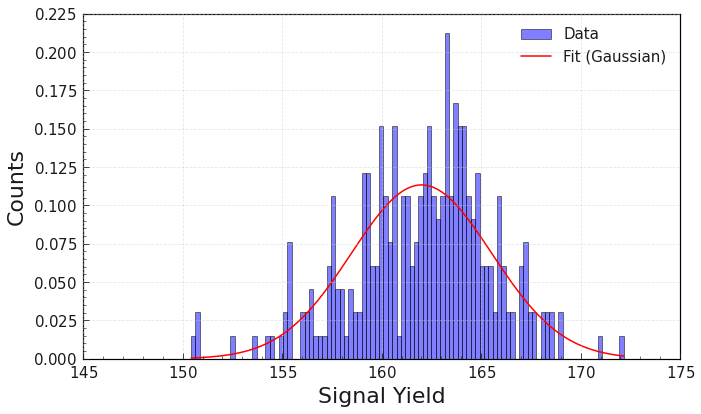

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name           value  (rounded)               errors    at limit
-----------  ------------------  -------------------  ----------
mu_0.091                162.005  -    4.6   +    4.6       False
sigma_0.091             3.52777  -    1.8   +    3.4       False
True


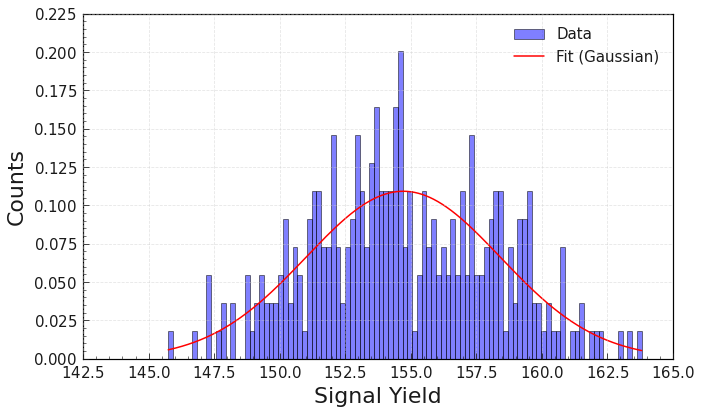

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.9965                154.712  -    6.6   +    6.6       False
sigma_0.9965              3.7071  -    5.4   +    5.4       False
True


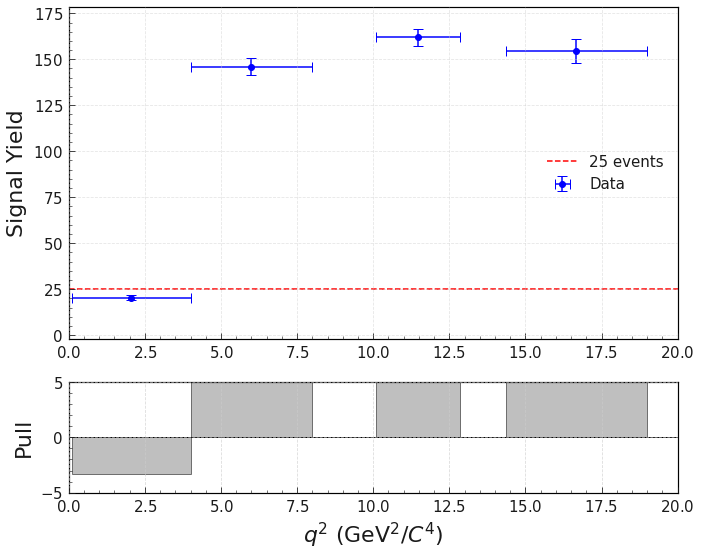

In [14]:
fit_and_plot_gaussian("Bppi0_q2reg1_decay_mumu_signal_yields_and_errors_25.csv", "Bppi0_q2reg1_decay_mumu_25", q2reg="(0.1, 4.0)", event_label="25")
fit_and_plot_gaussian("Bppi0_q2reg2_decay_mumu_signal_yields_and_errors_25.csv", "Bppi0_q2reg2_decay_mumu_25", q2reg="(4.0, 8.0)", event_label="25")
fit_and_plot_gaussian("Bppi0_q2reg3_decay_mumu_signal_yields_and_errors_25.csv", "Bppi0_q2reg3_decay_mumu_25", q2reg="(10.087, 12.859)", event_label="25")
fit_and_plot_gaussian("Bppi0_q2reg4_decay_mumu_signal_yields_and_errors_25.csv", "Bppi0_q2reg4_decay_mumu_25", q2reg="(14.349, 18.993)", event_label="25")


# Convert the list to a DataFrame with two columns: 'Signal_Yield' and 'Signal_Yield_Error'
events_df_25 = pd.DataFrame(events_and_errors_25, columns=['q2reg','MC_signal','mu', 'mu_error','sigma','sigma_error'])

# Save the DataFrame to a CSV file
events_df_25 .to_csv('Bppi0_q2reg_mumu_events_and_errors_25.csv', index=False)


plot_error_bar_with_pull_from_csv(
    file_path='Bppi0_q2reg_mumu_events_and_errors_25.csv',
    plot_title='Bppi0_q2reg_mumu_25',
    no_events=25
)

## 10 events

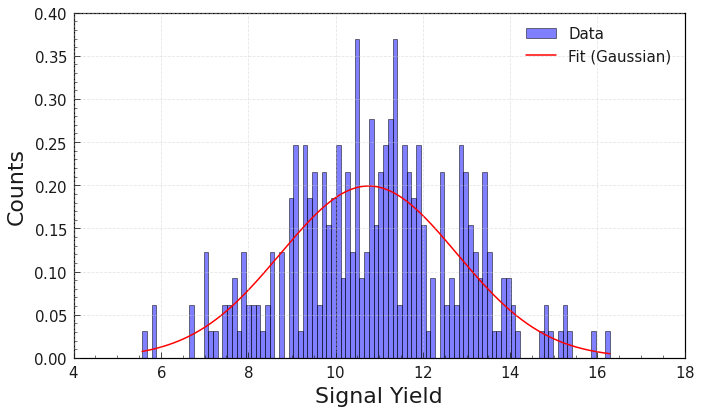

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.5438                 10.759  -   0.65   +   0.63       False
sigma_0.5438             2.01966  -   0.38   +   0.67       False
True


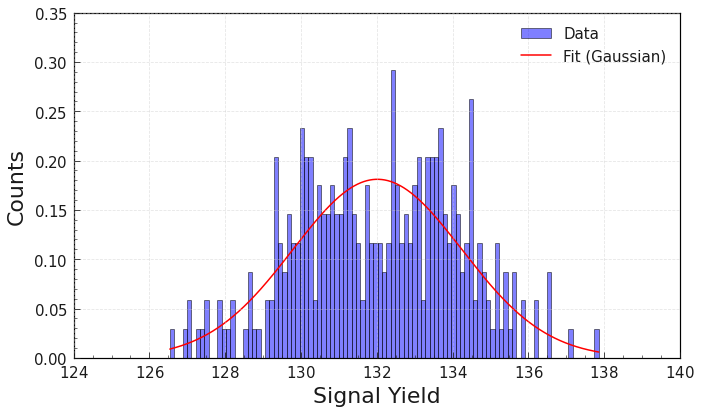

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.1389                132.016  -    2.8   +    2.8       False
sigma_0.1389             2.22898  -    1.1   +    2.2       False
True


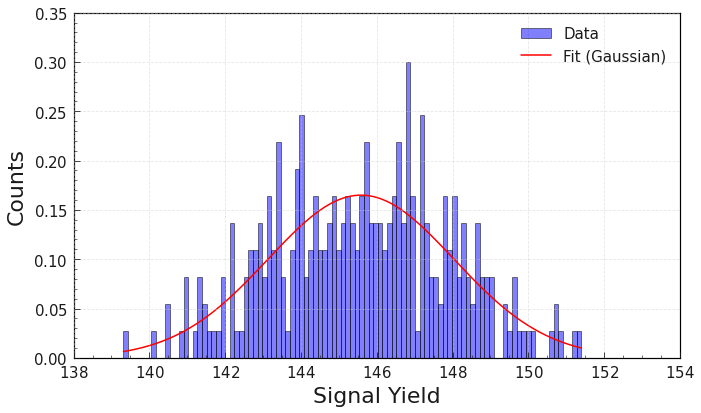

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.2335                145.583  -    3.3   +    3.3       False
sigma_0.2335             2.45307  -    2.7   +    2.7       False
True


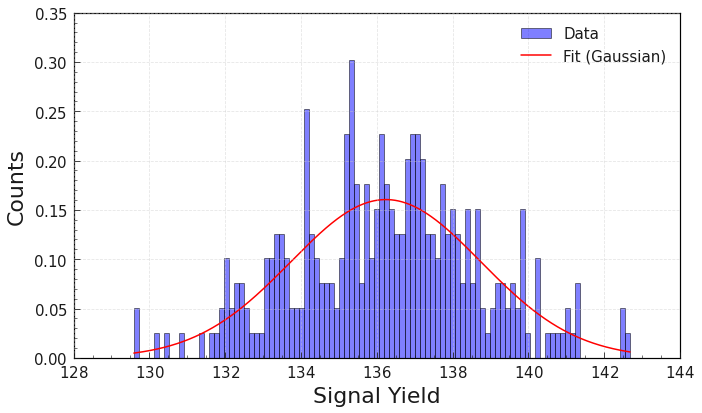

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.2673                136.239  -    4.3   +    4.3       False
sigma_0.2673             2.50884  -    3.4   +    3.4       False
True


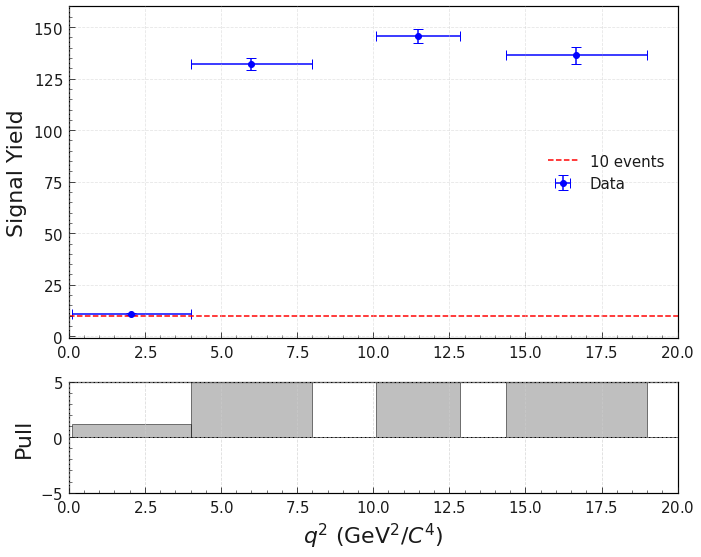

In [15]:
fit_and_plot_gaussian("Bppi0_q2reg1_decay_mumu_signal_yields_and_errors_10.csv", "Bppi0_q2reg1_decay_mumu_10", q2reg="(0.1, 4.0)", event_label="10")
fit_and_plot_gaussian("Bppi0_q2reg2_decay_mumu_signal_yields_and_errors_10.csv", "Bppi0_q2reg2_decay_mumu_10", q2reg="(4.0, 8.0)", event_label="10")
fit_and_plot_gaussian("Bppi0_q2reg3_decay_mumu_signal_yields_and_errors_10.csv", "Bppi0_q2reg3_decay_mumu_10", q2reg="(10.087, 12.859)", event_label="10")
fit_and_plot_gaussian("Bppi0_q2reg4_decay_mumu_signal_yields_and_errors_10.csv", "Bppi0_q2reg4_decay_mumu_10", q2reg="(14.349, 18.993)", event_label="10")


# Convert the list to a DataFrame with two columns: 'Signal_Yield' and 'Signal_Yield_Error'
events_df_10 = pd.DataFrame(events_and_errors_10, columns=['q2reg','MC_signal','mu', 'mu_error','sigma','sigma_error'])

# Save the DataFrame to a CSV file
events_df_10 .to_csv('Bppi0_q2reg_mumu_events_and_errors_10.csv', index=False)


plot_error_bar_with_pull_from_csv(
    file_path='Bppi0_q2reg_mumu_events_and_errors_10.csv',
    plot_title='Bppi0_q2reg_mumu_10',
    no_events=10
)

## 5 events

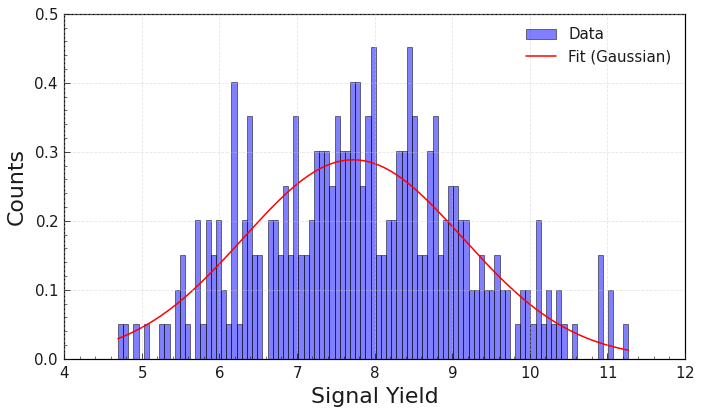

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.5425                7.72378  -   0.44   +    0.4       False
sigma_0.5425             1.41514  -   0.27   +   0.48       False
True


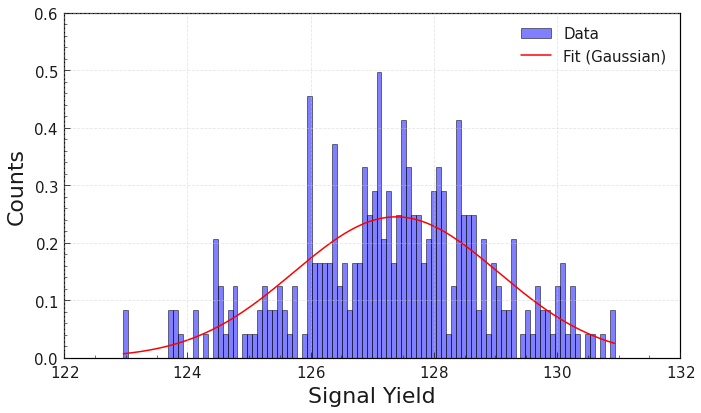

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.7645                127.387  -    2.1   +    2.1       False
sigma_0.7645             1.66139  -    1.8   +    1.8       False
True


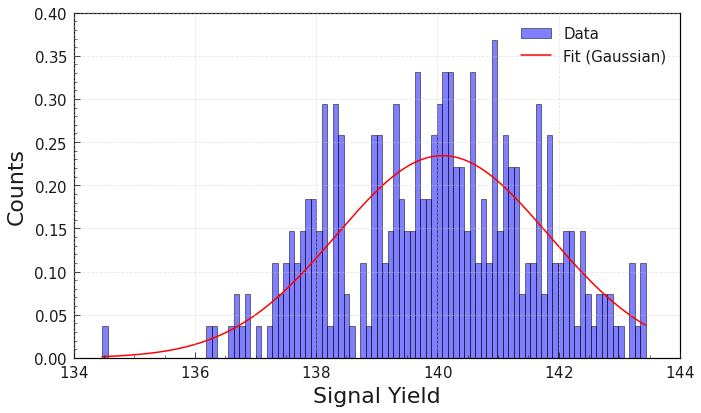

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.9911                140.085  -    2.5   +    2.5       False
sigma_0.9911             1.75269  -      2   +      2       False
True


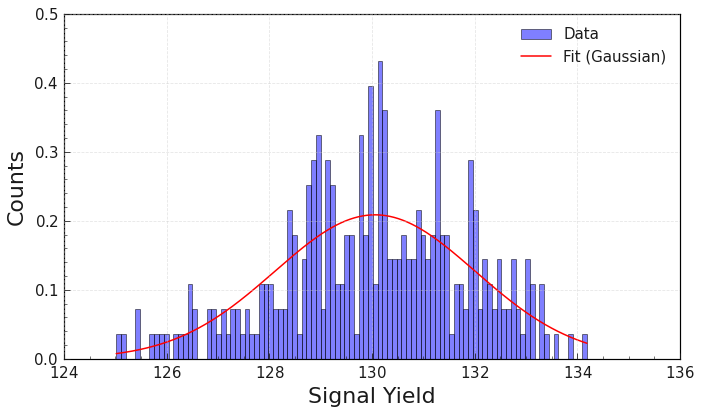

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.9933                130.058  -    3.5   +    3.5       False
sigma_0.9933             1.95621  -    2.9   +    2.9       False
True


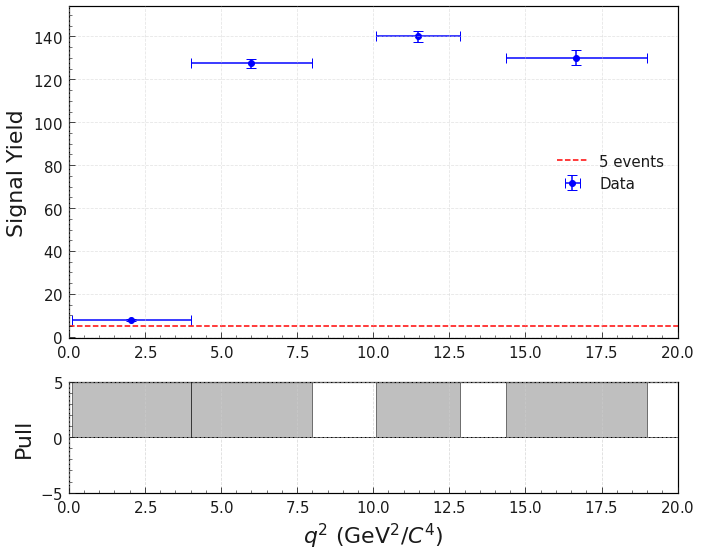

In [16]:
fit_and_plot_gaussian("Bppi0_q2reg1_decay_mumu_signal_yields_and_errors_5.csv", "Bppi0_q2reg1_decay_mumu_5", q2reg="(0.1, 4.0)", event_label="5")
fit_and_plot_gaussian("Bppi0_q2reg2_decay_mumu_signal_yields_and_errors_5.csv", "Bppi0_q2reg2_decay_mumu_5", q2reg="(4.0, 8.0)", event_label="5")
fit_and_plot_gaussian("Bppi0_q2reg3_decay_mumu_signal_yields_and_errors_5.csv", "Bppi0_q2reg3_decay_mumu_5", q2reg="(10.087, 12.859)", event_label="5")
fit_and_plot_gaussian("Bppi0_q2reg4_decay_mumu_signal_yields_and_errors_5.csv", "Bppi0_q2reg4_decay_mumu_5", q2reg="(14.349, 18.993)", event_label="5")


# Convert the list to a DataFrame with two columns: 'Signal_Yield' and 'Signal_Yield_Error'
events_df_5 = pd.DataFrame(events_and_errors_5, columns=['q2reg','MC_signal','mu', 'mu_error','sigma','sigma_error'])

# Save the DataFrame to a CSV file
events_df_5 .to_csv('Bppi0_q2reg_mumu_events_and_errors_5.csv', index=False)


plot_error_bar_with_pull_from_csv(
    file_path='Bppi0_q2reg_mumu_events_and_errors_5.csv',
    plot_title='Bppi0_q2reg_mumu_5',
    no_events=5
)

## 2 events

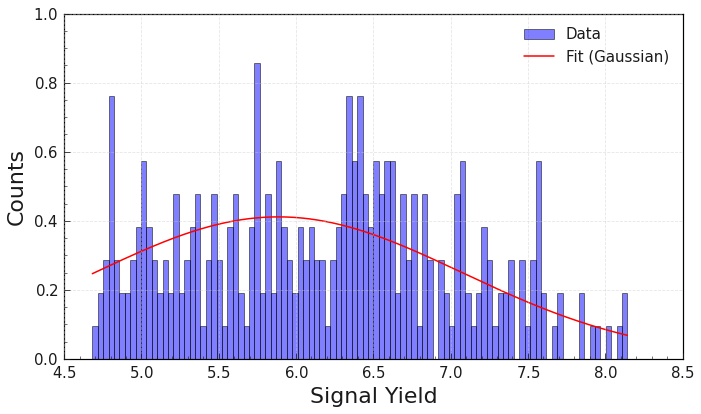

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.5031                5.88588  -    2.6   +   0.39       False
sigma_0.5031             1.19001  -   0.32   +      2       False
True


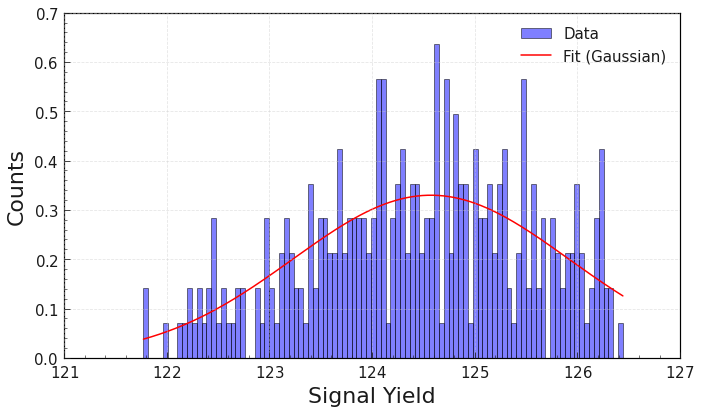

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.3951                124.572  -    2.1   +    2.1       False
sigma_0.3951             1.34556  -    2.1   +    2.1       False
True


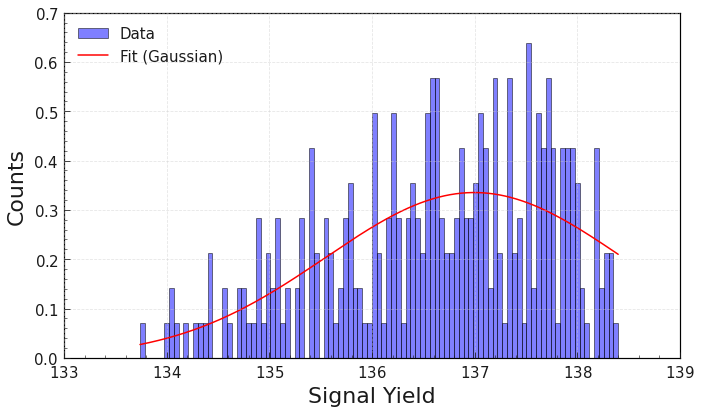

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.2206                136.995  -    3.2   +    3.2       False
sigma_0.2206             1.44962  -    2.7   +    2.7       False
True


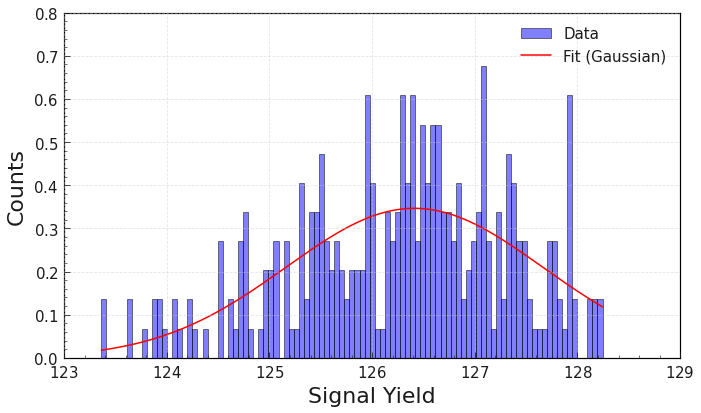

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.3452                126.412  -    2.7   +    2.7       False
sigma_0.3452             1.24944  -    2.3   +    2.3       False
True


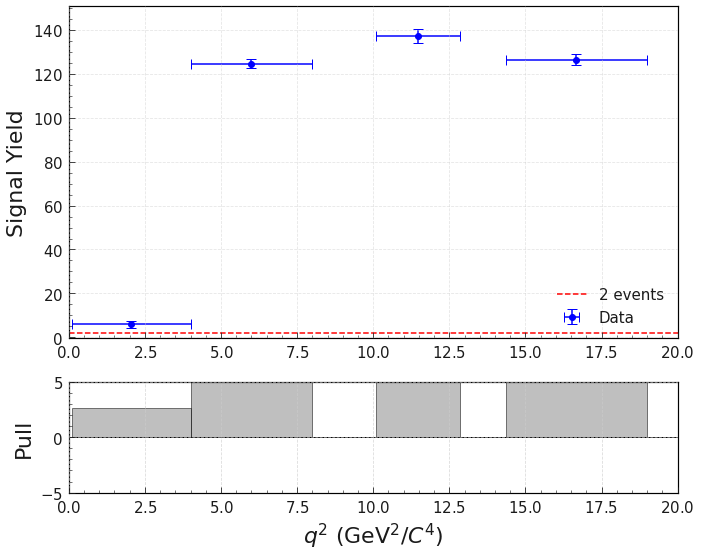

In [17]:
fit_and_plot_gaussian("Bppi0_q2reg1_decay_mumu_signal_yields_and_errors_2.csv", "Bppi0_q2reg1_decay_mumu_2", q2reg="(0.1, 4.0)", event_label="2")
fit_and_plot_gaussian("Bppi0_q2reg2_decay_mumu_signal_yields_and_errors_2.csv", "Bppi0_q2reg2_decay_mumu_2", q2reg="(4.0, 8.0)", event_label="2")
fit_and_plot_gaussian("Bppi0_q2reg3_decay_mumu_signal_yields_and_errors_2.csv", "Bppi0_q2reg3_decay_mumu_2", q2reg="(10.087, 12.859)", event_label="2")
fit_and_plot_gaussian("Bppi0_q2reg4_decay_mumu_signal_yields_and_errors_2.csv", "Bppi0_q2reg4_decay_mumu_2", q2reg="(14.349, 18.993)", event_label="2")


# Convert the list to a DataFrame with two columns: 'Signal_Yield' and 'Signal_Yield_Error'
events_df_2 = pd.DataFrame(events_and_errors_2, columns=['q2reg','MC_signal','mu', 'mu_error','sigma','sigma_error'])

# Save the DataFrame to a CSV file
events_df_2 .to_csv('Bppi0_q2reg_mumu_events_and_errors_2.csv', index=False)


plot_error_bar_with_pull_from_csv(
    file_path='Bppi0_q2reg_mumu_events_and_errors_2.csv',
    plot_title='Bppi0_q2reg_mumu_2',
    no_events=2
)

## 0

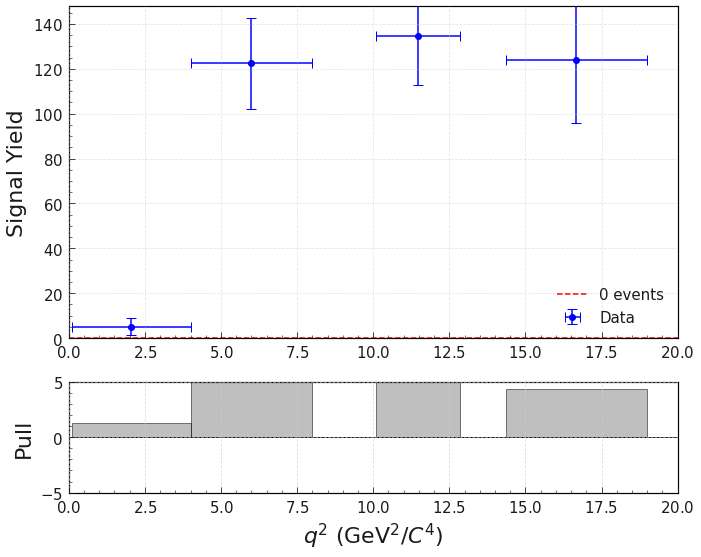

In [18]:
events_and_errors_0 = []

def fit_and_plot_gaussian(csv_file, plot_title, q2reg, event_label):
    # Load the CSV file
    ratios_df = pd.read_csv(csv_file)

    # Extract the Signal Yield and Signal Yield Error columns
    MC_data_signal= ratios_df["MC_signal"]
    signal_yields = ratios_df["Signal_Yield"]
    signal_yield_errors = ratios_df["Signal_Yield_Error"]

    # Obtain the result parameters
    mu_value = np.mean(signal_yields)
    mu_error = np.mean(signal_yield_errors)

    # mc_signal
    MC_signal= np.mean(MC_data_signal)
    
    if event_label == "0":
        events_and_errors_0.append((q2reg,MC_signal, mu_value, mu_error))


fit_and_plot_gaussian("Bppi0_q2reg1_decay_mumu_signal_yields_and_errors_0.csv", "Bppi0_q2reg1_decay_mumu_0", q2reg="(0.1, 4.0)", event_label="0")
fit_and_plot_gaussian("Bppi0_q2reg2_decay_mumu_signal_yields_and_errors_0.csv", "Bppi0_q2reg2_decay_mumu_0", q2reg="(4.0, 8.0)", event_label="0")
fit_and_plot_gaussian("Bppi0_q2reg3_decay_mumu_signal_yields_and_errors_0.csv", "Bppi0_q2reg3_decay_mumu_0", q2reg="(10.087, 12.859)", event_label="0")
fit_and_plot_gaussian("Bppi0_q2reg4_decay_mumu_signal_yields_and_errors_0.csv", "Bppi0_q2reg4_decay_mumu_0", q2reg="(14.349, 18.993)", event_label="0")


# Convert the list to a DataFrame with two columns: 'Signal_Yield' and 'Signal_Yield_Error'
events_df_0 = pd.DataFrame(events_and_errors_0, columns=['q2reg','MC_signal','mu', 'mu_error'])

# Save the DataFrame to a CSV file
events_df_0 .to_csv('Bppi0_q2reg_mumu_events_and_errors_0.csv', index=False)


# Call the function with the correct parameters
plot_error_bar_with_pull_from_csv(
    file_path='Bppi0_q2reg_mumu_events_and_errors_0.csv',
    plot_title='Bppi0_q2reg_mumu_0',
    no_events=0
)

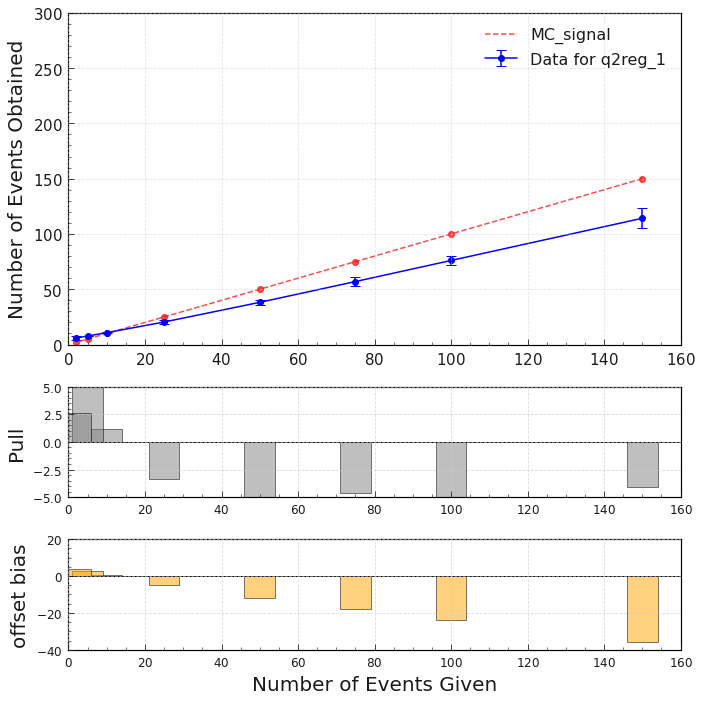

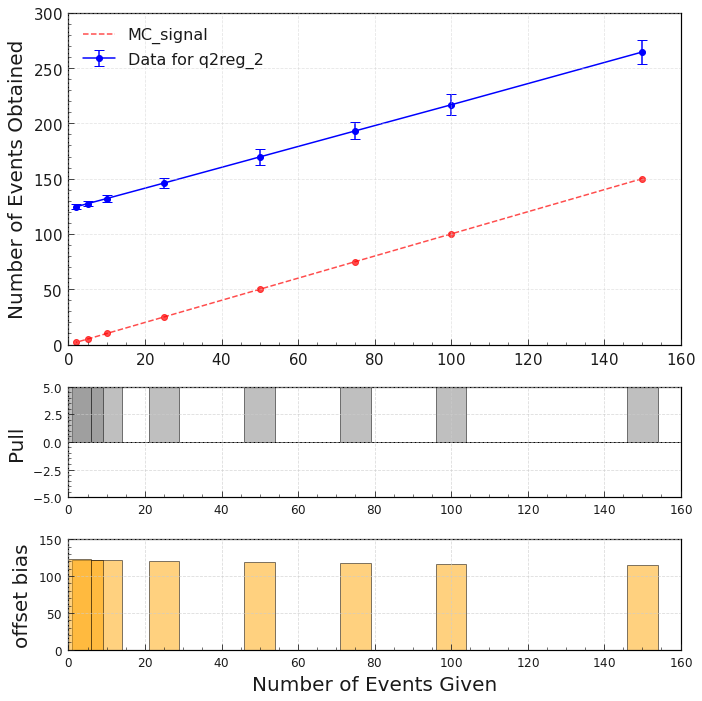

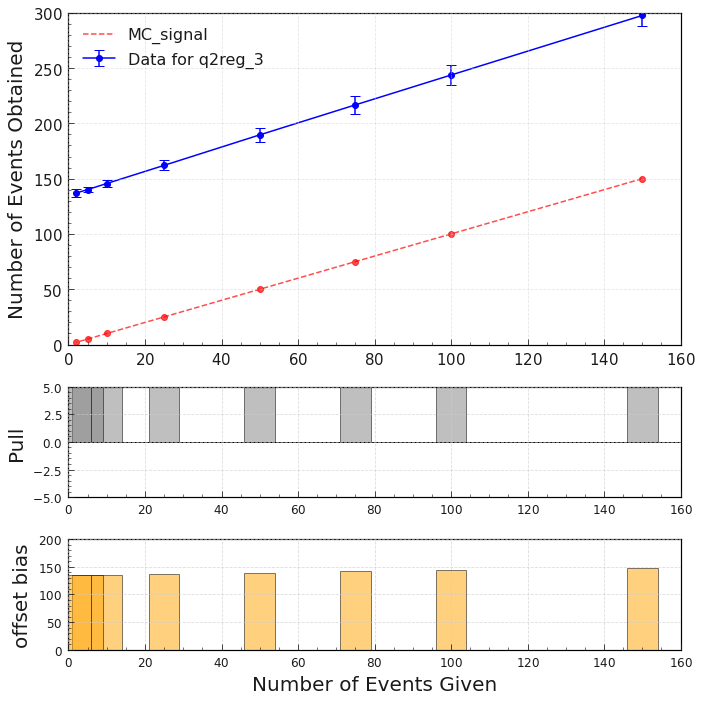

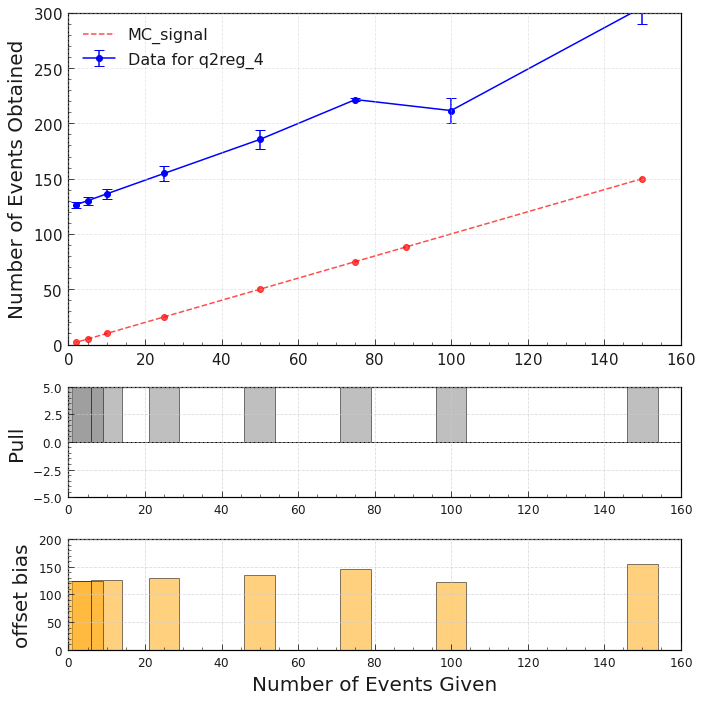

In [19]:
import matplotlib.pyplot as plt

# Define the number of events used in the experiments
event_levels = [150, 100, 75, 50, 25, 10, 5, 2]

# Prepare data structure for plotting
q2_ranges = ["(0.1, 4.0)", "(4.0, 8.0)", "(10.087, 12.859)", "(14.349, 18.993)"]
q2_labels = ["q2reg_1", "q2reg_2", "q2reg_3", "q2reg_4"]

event_data = {
    "(0.1, 4.0)": [],
    "(4.0, 8.0)": [],
    "(10.087, 12.859)": [],
    "(14.349, 18.993)": []
}


# Populate event_data with tuples of (event_level, MC_signal, mu, mu_error) for each q2 region
for data, label in zip([ events_and_errors_150, events_and_errors_100, events_and_errors_75,
                        events_and_errors_50, events_and_errors_25, events_and_errors_10, events_and_errors_5, events_and_errors_2,events_and_errors_0],
                       event_levels):
    for entry in data:
        q2reg, MC_signal, mu, mu_error, sigma, sigma_error = entry
        event_data[q2reg].append((label, MC_signal, mu, mu_error))

# Plotting
for q2reg, q2_label in zip(q2_ranges, q2_labels):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [3, 1, 1]})

    # Extract data for the current q2 region
    current_data = event_data[q2reg]
    
    # Separate event levels, mu values, and errors
    event_levels, MC_signal, mu_values, mu_errors = zip(*current_data)
    
    # Plot with error bars on the main plot (ax1)
    ax1.errorbar(event_levels, mu_values, yerr=mu_errors, fmt='o-', capsize=5, label=f'Data for {q2_label}', color='blue')
    
    # Plot the y=x line (ideal case where input equals output)
    ax1.plot(MC_signal, MC_signal, 'r--', label='MC_signal', alpha=0.7)
    ax1.scatter(MC_signal, MC_signal, color='red', alpha=0.7)
    
    # Labeling the main plot
    ax1.set_ylabel("Number of Events Obtained", fontsize=20)
    ax1.grid(True, linestyle='--', alpha=0.5)
    ax1.legend(prop={'size': 16})
    
    # Set x and y axis limits for ax1
    ax1.set_xlim(0, max(event_levels) + 10)
    ax1.set_ylim(0, 300)
    
    # Calculate the pull for each point
    pulls = [(mu - mc) / error if error != 0 else 0 for mc, mu, error in zip(MC_signal, mu_values, mu_errors)]
    
    # Plot the pull values on the bottom plot (ax3) as bars
    ax2.bar(event_levels, pulls, width=8, align='center', alpha=0.5, color='gray', edgecolor='black')

     # Labeling the pull plot
    #ax2.set_xlabel("Number of Events Given", fontsize=16)
    ax2.set_ylabel("Pull", fontsize=20)
    ax2.tick_params(axis='both', which='major', labelsize=12)
    ax2.grid(True, linestyle='--', alpha=0.7)

    # Calculate the offset bias for each point
    offsets = [mu - mc for mc, mu in zip(MC_signal, mu_values)]
    
    # Plot the offset bias on the middle plot (ax2) as bars
    ax3.bar(event_levels, offsets, width=8, align='center', alpha=0.5, color='orange', edgecolor='black')
    ax3.axhline(0, color='black', linewidth=1)
    ax3.set_xlabel("Number of Events Given", fontsize=20)
    ax3.set_ylabel("offset bias", fontsize=20)
    ax3.grid(True, linestyle='--', alpha=0.7)
    ax3.tick_params(axis='both', which='major', labelsize=12)

    # Horizontal line at y=0 for reference
    ax2.axhline(0, color='black', linewidth=1)
    
    # Set x-axis limits for ax2 and ax3 to match ax1
    ax2.set_xlim(ax1.get_xlim())
    ax3.set_xlim(ax1.get_xlim())
    
    # Set y-axis limits for pull plot
    ax2.set_ylim(-5, 5)  # Adjust limits as nmumuded to capture most of the pull range
    
    # Adjust layout with constrained_layout to ensure better alignment
    fig.tight_layout(h_pad=1.0)
    plt.savefig(f'Comparison_of_Input_vs_Output_Events_for_{q2_label}_Bppi0_mumu.pdf', format='pdf')
    plt.show()


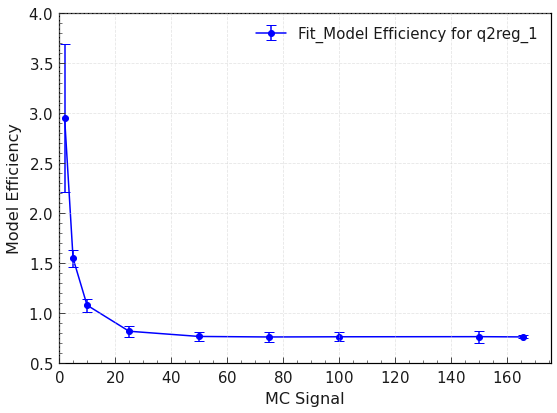

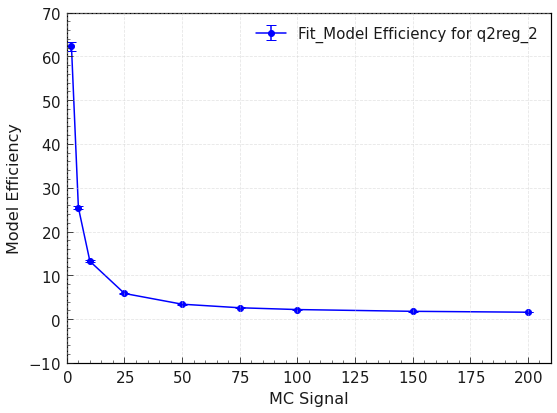

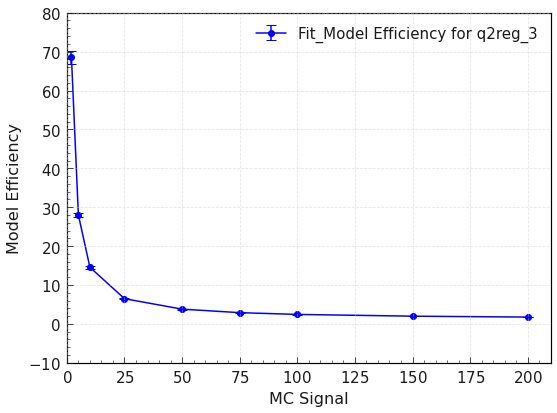

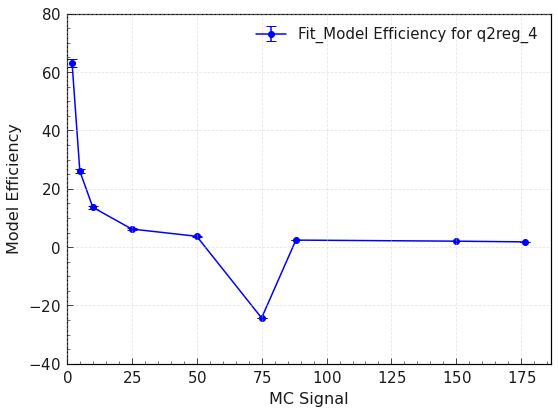

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the number of events used in the experiments
event_levels = [200, 150, 100, 75, 50, 25, 10, 5, 2]

# Prepare data structure for plotting
q2_ranges = ["(0.1, 4.0)", "(4.0, 8.0)", "(10.087, 12.859)", "(14.349, 18.993)"]
q2_labels = ["q2reg_1", "q2reg_2", "q2reg_3", "q2reg_4"]

event_data = {
    "(0.1, 4.0)": [],
    "(4.0, 8.0)": [],
    "(10.087, 12.859)": [],
    "(14.349, 18.993)": []
}

# Populate event_data with tuples of (event_level, MC_signal, mu, mu_error) for each q2 region
for data, label in zip([events_and_errors_200, events_and_errors_150, events_and_errors_100, events_and_errors_75,
                        events_and_errors_50, events_and_errors_25, events_and_errors_10, events_and_errors_5, events_and_errors_2],
                       event_levels):
    for entry in data:
        q2reg, MC_signal, mu, mu_error, sigma, sigma_error = entry
        event_data[q2reg].append((label, MC_signal, mu, mu_error))

# Plotting Fit_Model efficiency vs MC signal
for q2reg, q2_label in zip(q2_ranges, q2_labels):
    fig, ax = plt.subplots(figsize=(8, 6))

    # Extract data for the current q2 region
    current_data = event_data[q2reg]
    
    # Separate event levels, MC_signal, mu values, and errors
    event_levels, MC_signal, mu_values, mu_errors = zip(*current_data)
    
    # Convert to numpy arrays for calculations
    MC_signal = np.array(MC_signal)
    mu_values = np.array(mu_values)
    mu_errors = np.array(mu_errors)

    # Calculate Fit_Model efficiency
    Fit_Model_efficiency = mu_values / MC_signal
    
    # Calculate the uncertainty in Fit_Model efficiency
    eff_errors = mu_errors / MC_signal
    
    # Plot Fit_Model efficiency vs MC signal with error bars
    ax.errorbar(MC_signal, Fit_Model_efficiency, yerr=eff_errors, fmt='o-', label=f'Fit_Model Efficiency for {q2_label}', color='blue', capsize=5)
    
    # Labeling the plot
    ax.set_xlabel("MC Signal", fontsize=16)
    ax.set_ylabel("Model Efficiency", fontsize=16)
    #ax.set_title(f"Fit_Model Efficiency vs. MC Signal for {q2_label}_Bppi0_mumu", fontsize=16)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend()
    
    # Set x and y axis limits
    #ax.yscale("log")
    ax.set_xlim(0, max(MC_signal) + 10)
    #ax.set_ylim(0, 1.1)  # Efficiency is generally betwmumun 0 and 1
    
    # Save and show the plot
    plt.tight_layout()
    #plt.savefig(f'Fit_Model Efficiency vs MC Signal for {q2_label}_Bppi0_mumu.pdf', format='pdf')
    plt.show()
